In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

In [2]:
%matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
%reload_ext autoreload
%autoreload 2

Using matplotlib backend: MacOSX


In [3]:
import datetime # For datetime objects
import os.path # To manage paths
import sys # To find out the script name (in argv[0])
import pandas as pd
import quandl

In [4]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

In [406]:
class PandasData(btfeeds.DataBase):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', None),
    )

In [5]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('mafast', 1),
        ('maslow', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma_slow = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maslow)
        
        self.sma_fast = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.mafast)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' % 
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell(): # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f' % 
                     (order.executed.price,
                      order.executed.value,
                      order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma_fast[0] > self.sma_slow[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.sma_fast[0] < self.sma_slow[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Fast %2d Slow %2d) Ending Value %.2f' %
                 (self.params.mafast, self.params.maslow, self.broker.getvalue()), doprint=True)


In [6]:
# Create a cerebro entity
cerebro = bt.Cerebro()

In [7]:
cerebro.addstrategy(TestStrategy, mafast = 1, maslow = 18, printlog = True)

0

In [341]:
# Optimize thestrategy
strats = cerebro.optstrategy(
    TestStrategy,
    mafast=range(11, 100),
    maslow=1)

In [352]:
# Datas are in a subfolder of the samples. Need to find where the script is
# because it could have been called from anywhere
PATH = 'datas'
#modpath = os.path.dirname(os.path.abspath(sys.argv[0])); modpath
datapath = PATH + '/orcl-1995-2014.txt'; datapath

'datas/orcl-1995-2014.txt'

In [8]:
# Get ETH prices for GDAX exchange
eth = quandl.get("GDAX/ETH_BTC") 
eth.columns = [u'Open', u'High', u'Low', u'Volume'] # rename columns
eth['Close'] = eth['Open'].shift(-1)
eth = eth[['Open','High','Low','Close','Volume']]
eth = eth.dropna()
eth.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2018-06-26,0.07380,0.07390,0.07087,0.07110,7078.096775
2018-06-27,0.07110,0.07199,0.06994,0.07137,7091.752983
2018-06-28,0.07137,0.07217,0.07072,0.07178,4696.899976
2018-06-29,0.07178,0.07199,0.06915,0.06957,7667.003716
2018-06-30,0.06957,0.07175,0.06957,0.07050,3609.827617


In [9]:
# Use same time periods and dates as medium article
training_cutoff_date = "2017-05-19" 
training_cutoff_i = eth.index.get_loc(training_cutoff_date)
eth = eth.loc[:'2018-05-13'] # data up to 2018-05-13

In [10]:
# Chart of ETH price in BTC
eth['Close'].plot()

In [11]:
train = eth.iloc[:training_cutoff_i]; train

,Open,High,Low,Close,Volume
Date,,,,,
2016-05-26,0.02806,0.02948,0.02653,0.02779,22071.779283
2016-05-27,0.02779,0.02801,0.02206,0.02359,59852.842244
2016-05-28,0.02359,0.02506,0.02074,0.02191,53555.779792
2016-05-29,0.02191,0.02399,0.02174,0.02370,17760.147350
2016-05-30,0.02370,0.02428,0.02219,0.02372,8759.334422
2016-05-31,0.02372,0.02746,0.02340,0.02616,36640.854490
2016-06-01,0.02616,0.02735,0.02520,0.02589,14172.701277
2016-06-02,0.02589,0.02639,0.02529,0.02617,9171.186903
2016-06-03,0.02617,0.02618,0.02327,0.02408,29011.102669


In [12]:
data = bt.feeds.PandasData(dataname=train)

In [353]:
# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values before this date
    todate=datetime.datetime(2000, 12, 31),
    # Do not pass values after this date
    reverse=False)

In [456]:
# Add the Data Feed to Cerebro
cerebro.adddata(data)

In [457]:
# Set our desired cash start
cerebro.broker.setcash(1000.0)

In [458]:
# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

In [459]:
# Set the commission
cerebro.broker.setcommission(commission=0.0)

In [460]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00


In [461]:
# Run over everything
cerebro.run()

2016-06-12, Close, 0.02
2016-06-13, Close, 0.03
2016-06-13, BUY CREATE, 0.03
2016-06-14, BUY EXECUTED, Price: 0.03, Cost: 0.25, Comm 0.00
2016-06-14, Close, 0.03
2016-06-15, Close, 0.03
2016-06-16, Close, 0.03
2016-06-17, Close, 0.02
2016-06-17, SELL CREATE, 0.02
2016-06-18, SELL EXECUTED, Price: 0.02, Cost: 0.25, Comm: 0.00
2016-06-18, OPERATION PROFIT, GROSS -0.06, NET -0.06
2016-06-18, Close, 0.02
2016-06-19, Close, 0.02
2016-06-20, Close, 0.02
2016-06-21, Close, 0.02
2016-06-22, Close, 0.02
2016-06-23, Close, 0.02
2016-06-24, Close, 0.02
2016-06-25, Close, 0.02
2016-06-26, Close, 0.02
2016-06-27, Close, 0.02
2016-06-28, Close, 0.02
2016-06-29, Close, 0.02
2016-06-30, Close, 0.02
2016-07-01, Close, 0.02
2016-07-02, Close, 0.02
2016-07-03, Close, 0.02
2016-07-04, Close, 0.02
2016-07-05, Close, 0.02
2016-07-06, Close, 0.02
2016-07-07, Close, 0.02
2016-07-08, Close, 0.02
2016-07-09, Close, 0.02
2016-07-10, Close, 0.02
2016-07-11, Close, 0.02
2016-07-12, Close, 0.02
2016-07-13, Close, 0

In [462]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 1000.32


[[<Figure size 2880x1440 with 4 Axes>]]

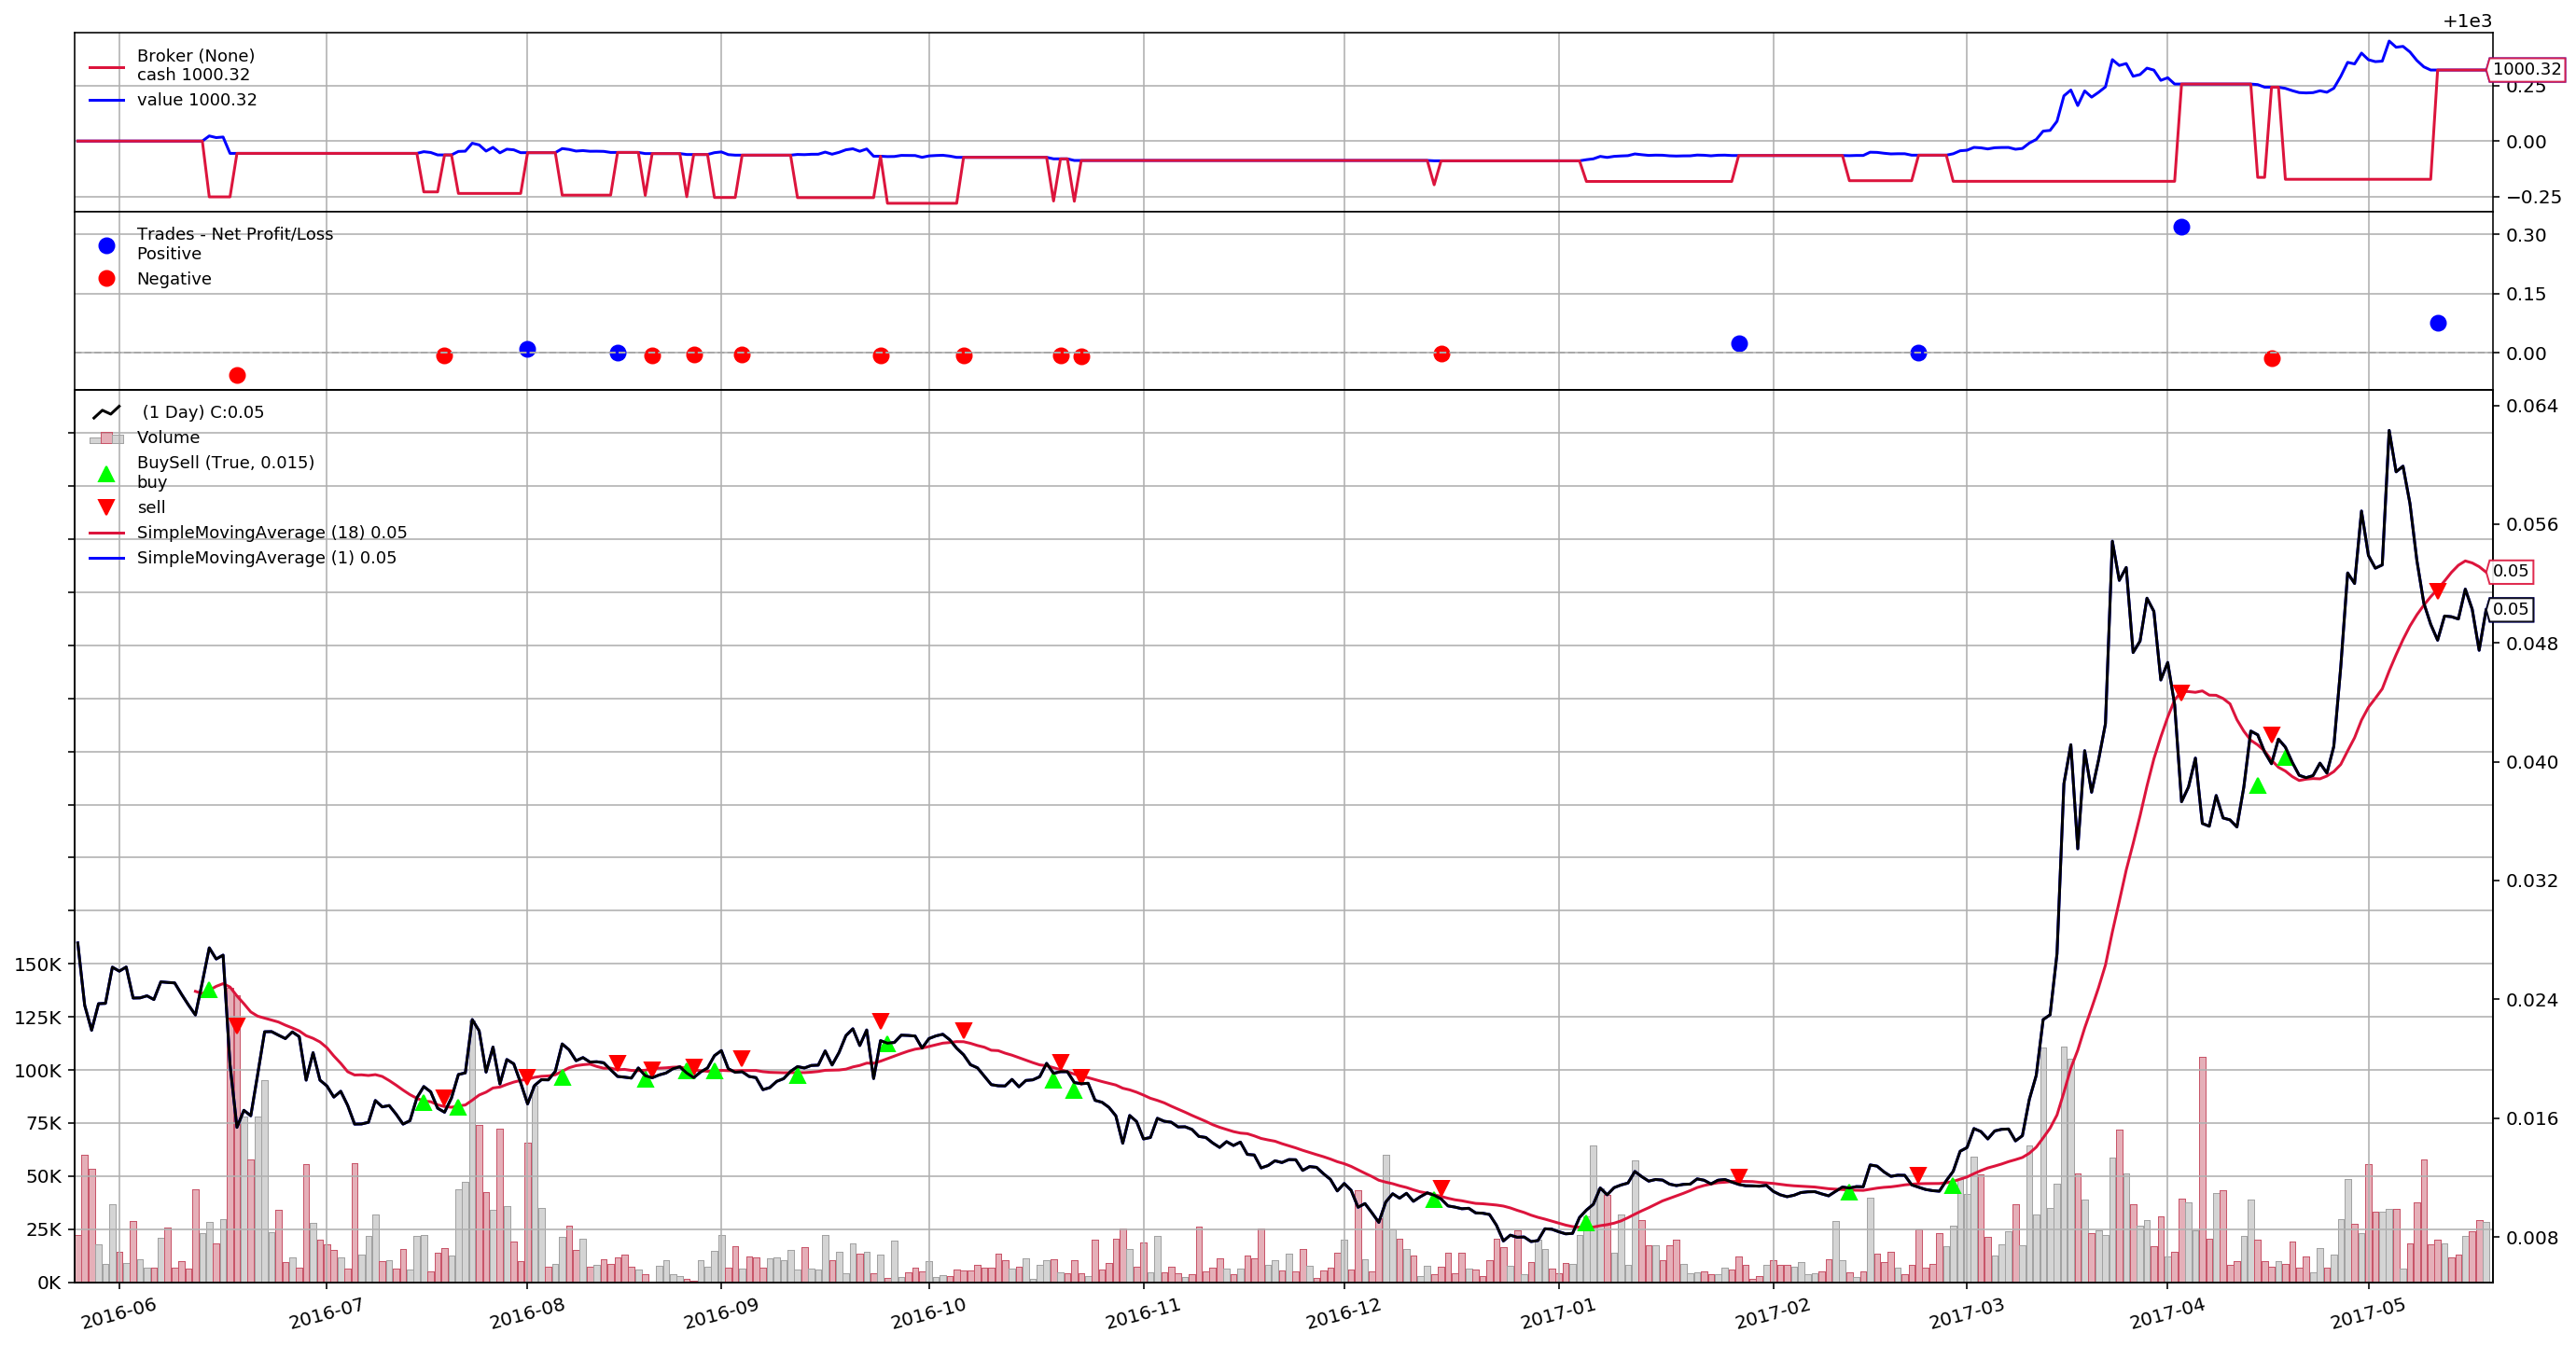

In [463]:
cerebro.plot(iplot=False)